# Performer Attention Optimization

Description:
------------
This notebook implements and optimizes a language model using the Performer attentino mechanism (from "Rethinking Attention with Performers" by Choromanski et al.) as an efficient alternative to the standard transformer attention.

Implementation Steps:
1. Load a pre-trained language model (GPT-2)– this is the "teacher" model.
2. Create a copy of the model architecture but replace its attention mechanism with Performer attention with the FAVOR+ kernel approximation technique.
3. Optimize the custom model's parameters by minimizing the KL-divergence between its output distribution and GPT-2's.
4. Demonstrate how to evaluate and compare both models on sample data.

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

checkpoint_dir = '/content/drive/MyDrive/model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

Mounted at /content/drive


In [ ]:
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import time
import os
import psutil

from transformers import (
    PreTrainedModel,
    PretrainedConfig,
    DataCollatorForLanguageModeling,
    AutoTokenizer,
    GPT2LMHeadModel,
    GPT2Config
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "gpt2"
SEQ_LEN = 128
BATCH_SIZE = 4
NUM_EPOCHS = 50
PERFORMER_FEATURES = 64

In [ ]:
# -------------------------------------------
# GPT-Performer Model Configuration
# -------------------------------------------

class GPTPerformerConfig(PretrainedConfig):
    model_type = "gpt-performer"

    def __init__(
        self,
        vocab_size,
        max_position_embeddings,
        n_embd,
        n_layer,
        n_head,
        hidden_dropout_prob,
        attention_probs_dropout_prob,
        performer_nb_features,
        performer_kernel_type,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.max_position_embeddings = max_position_embeddings
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.performer_nb_features = performer_nb_features
        self.performer_kernel_type = performer_kernel_type

In [ ]:
# -------------------------------------------
# Performer Attention
# -------------------------------------------

class PerformerAttention(nn.Module):
    """
    "Rethinking Attention with Performers" (Choromanski et al.)
    https://arxiv.org/abs/2009.14794
    """

    def __init__(
        self,
        embed_dim,
        num_heads,
        nb_features,
        dropout,
        kernel_type
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.nb_features = nb_features
        self.dropout = nn.Dropout(dropout)
        self.head_dim = embed_dim // num_heads

        # Q, K, V linear projections
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

        self.kernel_type = kernel_type

        # Random projection matrix for Performer
        projection_matrix = self._orthogonal_matrix_chunk(
            self.num_heads, self.head_dim, self.nb_features // 2
        )

        # Shape: [num_heads, head_dim, nb_features//2]
        self.register_buffer("projection_matrix", projection_matrix)

        # Suggested scaling factor
        self.feature_scaling = 1.0 / math.sqrt(self.head_dim)

    def _orthogonal_matrix_chunk(self, num_heads, head_dim, nb_features_per_head):
        """Creates blocks of orthogonal random Gaussian matrices."""
        blocks = []
        for _ in range(num_heads):
            q, _ = torch.qr(torch.randn(head_dim, nb_features_per_head * 2))
            q = q[:, :nb_features_per_head]
            blocks.append(q)

        matrix = torch.stack(blocks)
        return matrix

    def _kernel_fn(self, x, is_query, eps=1e-8):
        """
        Applies the FAVOR+ kernel approximation.

        Args:
            x: tensor of shape [batch, seq_len, num_heads, head_dim]
            is_query: whether x is a query or key

        Returns:
            Projected features with shape [batch, seq_len, num_heads, nb_features]
        """
        data_normalizer = 1.0 / (x.shape[-1] ** 0.25)
        x = x * data_normalizer

        # [B, S, H, D] x [H, D, F] -> [B, S, H, F]
        projection = torch.einsum("bshd,hdf->bshf", x, self.projection_matrix)

        # The core of FAVOR+ - different handling for queries vs keys
        if self.kernel_type == "softmax":
            if is_query:
                return torch.exp(projection)
            else:
                return torch.exp(-projection)
        elif self.kernel_type == "relu":
            return F.relu(projection)
        else:
            raise ValueError(f"Unsupported kernel type: {self.kernel_type}")

    def forward(self, hidden_states, attention_mask=None):
        """
        hidden_states: (batch_size, seq_len, embed_dim)
        attention_mask: (batch_size, 1, 1, seq_len) or None
        """
        batch_size, seq_len, _ = hidden_states.size()

        # Project Q, K, V
        q = self.query(hidden_states)  # [B, S, E]
        k = self.key(hidden_states)
        v = self.value(hidden_states)

        # Reshape to multiple heads
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim)

        q = q * self.feature_scaling

        # Apply attention mask if provided
        if attention_mask is not None:
            # In original transformers, mask is 0 for positions to attend, -inf for positions to ignore
            # Here we need to explicitly zero-out the values that shouldn't contribute
            v = v.permute(0, 2, 1, 3)  # [batch, heads, seq_len, head_dim]
            attention_mask = attention_mask.squeeze(2)       # [batch, 1, seq_len]
            attention_mask = attention_mask[:, :, :, None]   # [batch, 1, seq_len, 1]
            v = v * attention_mask

        # Apply FAVOR+ kernel approximation
        q_prime = self._kernel_fn(q, is_query=True)   # [B, S, H, F] for queries
        k_prime = self._kernel_fn(k, is_query=False)  # [B, S, H, F] for keys

        # Transpose to [B, H, S, F] to match einsum
        q_prime = q_prime.permute(0, 2, 1, 3)  # [B, H, S, F]
        k_prime = k_prime.permute(0, 2, 1, 3)  # [B, H, S, F]

        # Compute normalization factor z: sum over sequence length in keys
        k_sum = k_prime.sum(dim=2)            # [B, H, F]
        z = torch.einsum("bhsf,bhf->bhs", q_prime, k_sum)  # [B, H, S]

        # Compute numerator: (Q'K'^T)V ≈ Q'(K'V)
        kv = torch.einsum("bhsf,bhsd->bhfd", k_prime, v)   # [B, H, F, D]
        attn_output = torch.einsum("bhsf,bhfd->bhsd", q_prime, kv)  # [B, H, S, D]

        # Normalize
        z = z.unsqueeze(-1)                    # [B, H, S, 1]
        attn_output = attn_output / (z + 1e-8)  # [B, H, S, D]

        # Rearrange and project
        attn_output = attn_output.permute(0, 2, 1, 3).reshape(batch_size, seq_len, self.embed_dim)  # [B, S, D]
        attn_output = self.out(attn_output)
        attn_output = self.dropout(attn_output)

        return attn_output

In [ ]:
# -------------------------------------------
# GPT-Performer Block
# -------------------------------------------

class GPTPerformerBlock(nn.Module):
    """
    Single Transformer block that uses Performer attention.
    """

    def __init__(self, config: GPTPerformerConfig):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd, eps=1e-5)
        self.attn = PerformerAttention(
            embed_dim=config.n_embd,
            num_heads=config.n_head,
            nb_features=config.performer_nb_features,
            dropout=config.attention_probs_dropout_prob,
            kernel_type=config.performer_kernel_type,
        )
        self.ln_2 = nn.LayerNorm(config.n_embd, eps=1e-5)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.hidden_dropout_prob),
        )

    def forward(self, hidden_states, attention_mask=None):
        # Attention
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)
        hidden_states = self.attn(hidden_states, attention_mask=attention_mask)
        hidden_states = residual + hidden_states

        # MLP
        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        return hidden_states

In [ ]:
# -------------------------------------------
# Complete GPT-Performer Model
# -------------------------------------------

class GPTPerformerModel(PreTrainedModel):
    """
    A GPT-style language model using Performer attention.
    """

    config_class = GPTPerformerConfig

    def __init__(self, config: GPTPerformerConfig):
        super().__init__(config)
        self.embed_dim = config.n_embd

        # Embeddings
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)  # token embeddings
        self.wpe = nn.Embedding(config.max_position_embeddings, config.n_embd)  # positional embeddings
        self.drop = nn.Dropout(config.hidden_dropout_prob)

        # Blocks
        self.blocks = nn.ModuleList([GPTPerformerBlock(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd, eps=1e-5)

        # LM head
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.post_init()  # from PreTrainedModel

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,
        target_logits=None,
        **kwargs
    ):
        """
        input_ids: [batch_size, seq_len]
        attention_mask: [batch_size, seq_len]
        labels: optional, [batch_size, seq_len]
         target_logits: optional, teacher model logits for distillation
        """
        batch_size, seq_len = input_ids.shape
        device = input_ids.device

        position_ids = torch.arange(0, seq_len, dtype=torch.long, device=device)
        position_ids = position_ids.unsqueeze(0).expand(batch_size, seq_len)

        # Embed
        inputs_embeds = self.wte(input_ids)
        position_embeds = self.wpe(position_ids)
        hidden_states = inputs_embeds + position_embeds
        hidden_states = self.drop(hidden_states)

        # Extended attention mask if we want to incorporate pad tokens, etc.
        extended_mask = None
        if attention_mask is not None:
            extended_mask = attention_mask.unsqueeze(1).unsqueeze(2)  # [B, 1, 1, S]
            extended_mask = (1.0 - extended_mask) * -1e4

        # Pass through blocks
        for block in self.blocks:
            hidden_states = block(hidden_states, attention_mask=extended_mask)

        # Final layer norm
        hidden_states = self.ln_f(hidden_states)

        # LM head
        logits = self.lm_head(hidden_states)

        loss = None
        ce_loss = None
        kl_loss = None

        if labels is not None:
            # Next-token prediction: shift left
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            ce_loss = nn.CrossEntropyLoss()(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        if target_logits is not None:
            # KL Divergence between current logits and target (e.g., teacher model)
            shift_logits = logits[:, :-1, :].contiguous()
            shift_target_logits = target_logits[:, 1:, :].contiguous()

            kl_loss = nn.KLDivLoss(reduction="sum")(
                F.log_softmax(shift_logits, dim=-1),
                F.softmax(shift_target_logits, dim=-1)
            )
            kl_loss = kl_loss / attention_mask.sum()

        # Combine losses if both are present
        if ce_loss is not None and kl_loss is not None:
            loss = ce_loss + kl_loss
        elif ce_loss is not None:
            loss = ce_loss
        elif kl_loss is not None:
            loss = kl_loss

        if labels is not None or target_logits is not None:
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}

In [ ]:
# -------------------------------------------
# Data Loading: WikiText
# -------------------------------------------

from datasets import load_dataset

class WikiDataset(Dataset):
    def __init__(self, texts, tokenizer, seq_len):
        self.samples = []
        for text in texts:
            # Tokenize each text separately, without adding special tokens
            token_ids = tokenizer.encode(text, add_special_tokens=False)
            # Split token_ids into chunks of length seq_len
            for i in range(0, len(token_ids), seq_len):
                chunk = token_ids[i : i + seq_len]
                # Only add full chunks to avoid very short sequences
                if len(chunk) == seq_len:
                    self.samples.append(torch.tensor(chunk))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

dataset_split = load_dataset("wikitext", "wikitext-2-raw-v1", split=["train[:90%]", "train[90%:]"])
train_texts = dataset_split[0]["text"]
val_texts = dataset_split[1]["text"]

train_dataset = WikiDataset(train_texts, tokenizer, SEQ_LEN)
val_dataset = WikiDataset(val_texts, tokenizer, SEQ_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [ ]:
class UsageTracker:
    def __init__(self):
        self.start_time = None
        self.start_cpu_time = None
        self.train_stats = {
            "epoch": [], "step": [],
            "wall_time_s": [], "cpu_time_s": [],
            "cpu_mem_mb": [], "gpu_alloc_mb": [], "gpu_reserved_mb": []
        }
        self.infer_stats = {
            "max_token_length": [],
            "wall_time_s": [], "cpu_time_s": [],
            "cpu_mem_mb": [], "gpu_alloc_mb": [], "gpu_reserved_mb": []
        }

    def start_tracking(self):
        self.start_time = time.time()
        self.start_cpu_time = time.process_time()

    def stop_tracking(self, is_training, epoch=None, step=None, max_token_length=None):
        if self.start_time is None or self.start_cpu_time is None:
            raise ValueError("Tracking not started. Call start_tracking() first.")

        end_time = time.time()
        end_cpu_time = time.process_time()

        proc = psutil.Process(os.getpid())
        cpu_mem = proc.memory_info().rss / (1024**2)
        if torch.cuda.is_available():
            gpu_alloc    = torch.cuda.memory_allocated(DEVICE) / (1024**2)
            gpu_reserved = torch.cuda.memory_reserved(DEVICE) / (1024**2)
        else:
            gpu_alloc = gpu_reserved = 0.0

        obj = self.train_stats if is_training else self.infer_stats
        obj["wall_time_s"].append(end_time - self.start_time)
        obj["cpu_time_s"].append(end_cpu_time - self.start_cpu_time)
        obj["cpu_mem_mb"].append(cpu_mem)
        obj["gpu_alloc_mb"].append(gpu_alloc)
        obj["gpu_reserved_mb"].append(gpu_reserved)
        if is_training:
            obj["epoch"].append(epoch + 1)
            obj["step"].append(step + 1)
        else:
            obj["max_token_length"].append(max_token_length)

        self.start_time = None
        self.start_cpu_time = None

    def plot(self):
        df_train = pd.DataFrame(self.train_stats)
        df_inf   = pd.DataFrame(self.infer_stats)

        # --- Training plots (line plots vs. step) ---
        for metric in ["wall_time_s", "cpu_time_s", "cpu_mem_mb", "gpu_alloc_mb", "gpu_reserved_mb"]:
            plt.figure(figsize=(8, 4))
            plt.plot(df_train["step"], df_train[metric])
            plt.xlabel("Training Step")
            plt.ylabel(metric.replace("_", " ").title())
            plt.title(f"{metric.replace('_', ' ').title()} During Training")
            plt.show()

        prompt_lengths = self.infer_stats["max_token_length"]

        # --- Inference plots (bar plots vs. token length) ---
        for metric in ["wall_time_s", "cpu_time_s", "cpu_mem_mb", "gpu_alloc_mb", "gpu_reserved_mb"]:
            plt.figure(figsize=(8, 4))
            plt.scatter(prompt_lengths, self.infer_stats[metric])
            plt.xlabel("Prompt Token Length")
            plt.ylabel(metric.replace("_", " ").title())
            plt.title(f"{metric.replace('_', ' ').title()} vs. Prompt Length")
            plt.show()

In [ ]:
# Initialize model and optimizer
# Teacher model (original GPT-2)
teacher_model = GPT2LMHeadModel.from_pretrained("gpt2")

# Student model (GPT-Performer)
config = GPTPerformerConfig(
    vocab_size=len(tokenizer),
    max_position_embeddings=1024,
    n_embd=768,
    n_layer=12,
    n_head=12,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    performer_nb_features=PERFORMER_FEATURES,
    performer_kernel_type="softmax",
)
performer_model = GPTPerformerModel(config)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

<ipython-input-5-fafe55a46318>:49: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2485.)
  q, _ = torch.qr(torch.randn(head_dim, nb_features_per_head * 2))


In [ ]:
def copy_weights_from_gpt2(performer_model, teacher_model):
    performer_state_dict = performer_model.state_dict()
    teacher_state_dict = teacher_model.state_dict()

    if 'wte.weight' in teacher_state_dict and 'wte.weight' in performer_state_dict:
        performer_state_dict['wte.weight'].copy_(teacher_state_dict['wte.weight'])

    if 'wpe.weight' in teacher_state_dict and 'wpe.weight' in performer_state_dict:
        performer_state_dict['wpe.weight'].copy_(teacher_state_dict['wpe.weight'])

    if 'lm_head.weight' in teacher_state_dict and 'lm_head.weight' in performer_state_dict:
        performer_state_dict['lm_head.weight'].copy_(teacher_state_dict['lm_head.weight'])

    for i in range(min(config.n_layer, len(teacher_model.transformer.h))):
        for ln_type in ['ln_1', 'ln_2']:
            for param in ['weight', 'bias']:
                teacher_key = f'transformer.h.{i}.{ln_type}.{param}'
                performer_key = f'blocks.{i}.{ln_type}.{param}'

                if teacher_key in teacher_state_dict and performer_key in performer_state_dict:
                    performer_state_dict[performer_key].copy_(teacher_state_dict[teacher_key])

    if 'transformer.ln_f.weight' in teacher_state_dict and 'ln_f.weight' in performer_state_dict:
        performer_state_dict['ln_f.weight'].copy_(teacher_state_dict['transformer.ln_f.weight'])

    if 'transformer.ln_f.bias' in teacher_state_dict and 'ln_f.bias' in performer_state_dict:
        performer_state_dict['ln_f.bias'].copy_(teacher_state_dict['transformer.ln_f.bias'])

    for i in range(config.n_layer):
        # First MLP layer (c_fc -> 0)
        teacher_fc_weight = teacher_state_dict[f'transformer.h.{i}.mlp.c_fc.weight']
        teacher_fc_bias = teacher_state_dict[f'transformer.h.{i}.mlp.c_fc.bias']

        # Transpose the weight matrix - GPT-2 uses [hidden_size, ff_size] but performer uses [ff_size, hidden_size]
        performer_state_dict[f'blocks.{i}.mlp.0.weight'].copy_(teacher_fc_weight.t())
        performer_state_dict[f'blocks.{i}.mlp.0.bias'].copy_(teacher_fc_bias)

        # Second MLP layer (c_proj -> 2)
        teacher_proj_weight = teacher_state_dict[f'transformer.h.{i}.mlp.c_proj.weight']
        teacher_proj_bias = teacher_state_dict[f'transformer.h.{i}.mlp.c_proj.bias']

        # Transpose the weight matrix - GPT-2 uses [ff_size, hidden_size] but performer uses [hidden_size, ff_size]
        performer_state_dict[f'blocks.{i}.mlp.2.weight'].copy_(teacher_proj_weight.t())
        performer_state_dict[f'blocks.{i}.mlp.2.bias'].copy_(teacher_proj_bias)

    performer_model.load_state_dict(performer_state_dict)

    return performer_model

performer_model = copy_weights_from_gpt2(performer_model, teacher_model)

In [ ]:
# Training loop

def train(performer_model, teacher_model, train_dataloader, val_dataloader, device, temperature=0.7):
    """
    Train the performer model with KL divergence loss between performer and GPT-2 logits

    Args:
        performer_model: GPTPerformerModel instance
        teacher_model: Original GPT2LMHeadModel instance (frozen)
        train_dataloader: Training data loader
        val_dataloader: Validation data loader
        temperature: Temperature for softening the logits
    """
    performer_model.to(device)
    teacher_model.to(device)

    for param in teacher_model.parameters():
        param.requires_grad = False

    for epoch in range(NUM_EPOCHS):
        performer_model.train()
        teacher_model.eval()  # Always in eval mode

        total_loss = 0.0

        for step, batch in enumerate(train_dataloader):
            tracker.start_tracking()
            input_ids = batch[:, :-1].to(device)
            labels = batch[:, 1:].to(device)
            attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)

            with torch.no_grad():
                teacher_outputs = teacher_model(input_ids=input_ids,
                                              attention_mask=attention_mask,
                                              labels=labels)
                teacher_logits = teacher_outputs.logits if hasattr(teacher_outputs, "logits") else teacher_outputs[0]

            performer_outputs = performer_model(input_ids=input_ids,
                                              attention_mask=attention_mask,
                                              labels=labels,
                                              target_logists=teacher_logits)

            loss = performer_outputs["loss"]

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track losses
            loss_val = loss.item()
            total_loss += loss_val

            tracker.stop_tracking(is_training=True, epoch=epoch, step=step)

            if (step + 1) % 100 == 0:
                print(f"Epoch {epoch+1} Step {step+1} -  Loss: {loss_val:.4f}")

        scheduler.step()

        # Calculate average loss
        avg_train_loss = total_loss / len(train_dataloader)
        train_loss_vals.append(avg_train_loss)
        print(f"Epoch {epoch+1} Training - Loss: {avg_train_loss:.4f}")

        # Validation loop
        performer_model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch.to(device)
                attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)

                # Get logits from both models
                teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
                teacher_logits = teacher_outputs.logits if hasattr(teacher_outputs, "logits") else teacher_outputs[0]

                performer_outputs = performer_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    target_logits=teacher_logits
                )

                val_loss = performer_outputs["loss"]

                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_loss_vals.append(avg_val_loss)
        print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")

        # Save checkpoint
        if (epoch + 1) % 5 == 0 or epoch == NUM_EPOCHS - 1:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': performer_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss_vals,
                'val_loss': val_loss_vals,
                'tracker': tracker
            }
            checkpoint_path = os.path.join(checkpoint_dir, f'performer_epoch_{epoch+1}.pth')
            torch.save(checkpoint, checkpoint_path)
            print(f"Model checkpoint saved to {checkpoint_path}")

    return train_loss_vals, val_loss_vals

In [ ]:
tracker = UsageTracker()
train_loss_vals = []
val_loss_vals = []
optimizer = torch.optim.AdamW(performer_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)

# Train with KL distillation
train_losses, val_losses = train(
    performer_model=performer_model,
    teacher_model=teacher_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=DEVICE
)

# Save the trained performer model
performer_model.save_pretrained("gpt-performer-distilled")
tokenizer.save_pretrained("gpt-performer-distilled")

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1 Step 100 -  Loss: 7.1064
Epoch 1 Step 200 -  Loss: 7.7014
Epoch 1 Step 300 -  Loss: 7.5953
Epoch 1 Step 400 -  Loss: 7.4410
Epoch 1 Step 500 -  Loss: 7.1432
Epoch 1 Step 600 -  Loss: 7.2056
Epoch 1 Step 700 -  Loss: 7.5117
Epoch 1 Step 800 -  Loss: 6.8725
Epoch 1 Step 900 -  Loss: 7.4330
Epoch 1 Step 1000 -  Loss: 6.7867
Epoch 1 Step 1100 -  Loss: 7.5021
Epoch 1 Step 1200 -  Loss: 6.9805
Epoch 1 Step 1300 -  Loss: 7.1137
Epoch 1 Step 1400 -  Loss: 7.3787
Epoch 1 Step 1500 -  Loss: 6.8638
Epoch 1 Step 1600 -  Loss: 6.5339
Epoch 1 Step 1700 -  Loss: 7.2182
Epoch 1 Step 1800 -  Loss: 7.0381
Epoch 1 Step 1900 -  Loss: 6.9300
Epoch 1 Step 2000 -  Loss: 6.3575
Epoch 1 Step 2100 -  Loss: 6.9736
Epoch 1 Step 2200 -  Loss: 6.8348
Epoch 1 Step 2300 -  Loss: 6.9371
Epoch 1 Training - Loss: 7.1806
Epoch 1 Validation Loss: 4.0834
Epoch 2 Step 100 -  Loss: 6.5762
Epoch 2 Step 200 -  Loss: 6.6398
Epoch 2 Step 300 -  Loss: 6.7502
Epoch 2 Step 400 -  Loss: 7.0965
Epoch 2 Step 500 -  Loss: 6.313

In [ ]:
# Training loop

def train_checkpoint(performer_model, teacher_model, train_dataloader, val_dataloader, device, temperature=0.7):
    """
    Train the performer model with KL divergence loss between performer and GPT-2 logits

    Args:
        performer_model: GPTPerformerModel instance
        teacher_model: Original GPT2LMHeadModel instance (frozen)
        train_dataloader: Training data loader
        val_dataloader: Validation data loader
        temperature: Temperature for softening the logits
    """
    performer_model.to(device)
    teacher_model.to(device)

    for param in teacher_model.parameters():
        param.requires_grad = False

    for epoch in range(30, 50):
        performer_model.train()
        teacher_model.eval()  # Always in eval mode

        total_loss = 0.0

        for step, batch in enumerate(train_dataloader):
            tracker.start_tracking()
            input_ids = batch[:, :-1].to(device)
            labels = batch[:, 1:].to(device)
            attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)

            with torch.no_grad():
                teacher_outputs = teacher_model(input_ids=input_ids,
                                              attention_mask=attention_mask,
                                              labels=labels)
                teacher_logits = teacher_outputs.logits if hasattr(teacher_outputs, "logits") else teacher_outputs[0]

            performer_outputs = performer_model(input_ids=input_ids,
                                              attention_mask=attention_mask,
                                              labels=labels,
                                              target_logists=teacher_logits)

            loss = performer_outputs["loss"]

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track losses
            loss_val = loss.item()
            total_loss += loss_val

            tracker.stop_tracking(is_training=True, epoch=epoch, step=step)

            if (step + 1) % 100 == 0:
                print(f"Epoch {epoch+1} Step {step+1} -  Loss: {loss_val:.4f}")

        scheduler.step()

        # Calculate average loss
        avg_train_loss = total_loss / len(train_dataloader)
        train_loss_vals.append(avg_train_loss)
        print(f"Epoch {epoch+1} Training - Loss: {avg_train_loss:.4f}")

        # Validation loop
        performer_model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch.to(device)
                attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)

                # Get logits from both models
                teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
                teacher_logits = teacher_outputs.logits if hasattr(teacher_outputs, "logits") else teacher_outputs[0]

                performer_outputs = performer_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    target_logits=teacher_logits
                )

                val_loss = performer_outputs["loss"]

                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_loss_vals.append(avg_val_loss)
        print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")

        # Save checkpoint
        if (epoch + 1) % 5 == 0 or epoch == NUM_EPOCHS - 1:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': performer_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss_vals,
                'val_loss': val_loss_vals,
                'tracker': tracker
            }
            checkpoint_path = os.path.join(checkpoint_dir, f'performer_epoch_{epoch+1}.pth')
            torch.save(checkpoint, checkpoint_path)
            print(f"Model checkpoint saved to {checkpoint_path}")

    return train_loss_vals, val_loss_vals

In [ ]:
checkpoint_path = os.path.join(checkpoint_dir, 'performer_epoch_30.pth')

checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
performer_model.load_state_dict(checkpoint['model_state_dict'])

optimizer = torch.optim.AdamW(performer_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 30)

optimizer_state = checkpoint['optimizer_state_dict']

for state in optimizer_state['state'].values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(DEVICE)

optimizer.load_state_dict(optimizer_state)

scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

train_loss_vals = checkpoint['train_loss']
val_loss_vals = checkpoint['val_loss']
tracker = checkpoint['tracker']

train_losses, val_losses = train_checkpoint(
    performer_model=performer_model,
    teacher_model=teacher_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=DEVICE
)

Epoch 31 Step 100 -  Loss: 2.6420
Epoch 31 Step 200 -  Loss: 2.6681
Epoch 31 Step 300 -  Loss: 2.7356
Epoch 31 Step 400 -  Loss: 2.6569
Epoch 31 Step 500 -  Loss: 2.7323
Epoch 31 Step 600 -  Loss: 2.7075
Epoch 31 Step 700 -  Loss: 2.8219
Epoch 31 Step 800 -  Loss: 2.8043
Epoch 31 Step 900 -  Loss: 2.7355
Epoch 31 Step 1000 -  Loss: 2.9666
Epoch 31 Step 1100 -  Loss: 2.8850
Epoch 31 Step 1200 -  Loss: 2.8095
Epoch 31 Step 1300 -  Loss: 2.8960
Epoch 31 Step 1400 -  Loss: 2.7468
Epoch 31 Step 1500 -  Loss: 2.8412
Epoch 31 Step 1600 -  Loss: 2.7749
Epoch 31 Step 1700 -  Loss: 3.0265
Epoch 31 Step 1800 -  Loss: 3.0502
Epoch 31 Step 1900 -  Loss: 3.0117
Epoch 31 Step 2000 -  Loss: 3.0979
Epoch 31 Step 2100 -  Loss: 2.8896
Epoch 31 Step 2200 -  Loss: 3.0112
Epoch 31 Step 2300 -  Loss: 2.9773
Epoch 31 Training - Loss: 2.8177
Epoch 31 Validation Loss: 8.3475
Epoch 32 Step 100 -  Loss: 2.5745
Epoch 32 Step 200 -  Loss: 2.6304
Epoch 32 Step 300 -  Loss: 2.6845
Epoch 32 Step 400 -  Loss: 2.6932
Ep

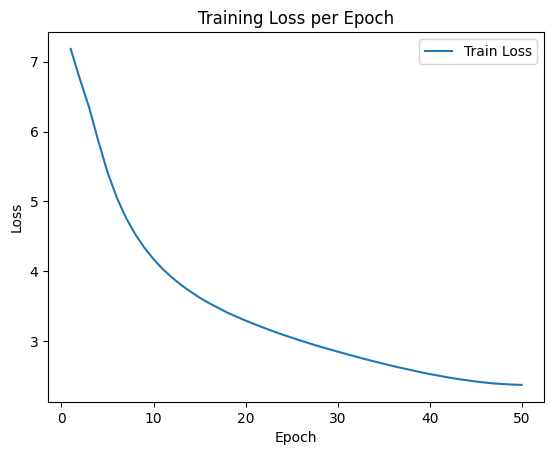

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_loss_vals) + 1))

# Plot training loss
plt.plot(epochs, train_loss_vals, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.show()

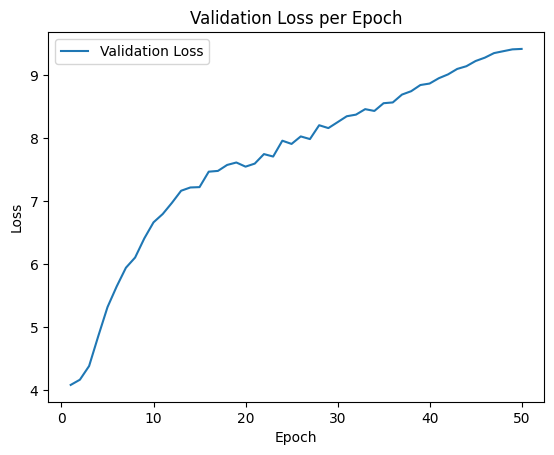

In [ ]:
epochs = list(range(1, len(val_loss_vals) + 1))

plt.plot(epochs, val_loss_vals, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss per Epoch")
plt.legend()
plt.show()

In [ ]:
def generate_text(model, prompt, max_length=50, temperature=0.7, top_k=50):
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        sequences = model.generate(
            inputs.input_ids,
            max_length=max_length,
            do_sample=True,
            temperature=temperature,
            top_k=top_k,
            pad_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.2,
            no_repeat_ngram_size=2,
            use_cache=False  # Disable caching if needed for Performer
        )

    seq_len = sequences.size(1)
    output = tokenizer.decode(sequences[0], skip_special_tokens=True)

    return output

In [ ]:
def generate_from_performer(model, prompt, max_length=50, temperature=0.7, top_k=50):
    """
    Custom generation function for GPTPerformerModel that doesn't rely on the HuggingFace generate() method.

    Args:
        model: The GPTPerformerModel instance
        prompt: String prompt to start generation with
        max_length: Maximum number of tokens to generate
        temperature: Sampling temperature (higher = more random)
        top_k: Number of highest probability tokens to consider for sampling

    Returns:
        The generated text as a string
    """
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(DEVICE)
    attention_mask = torch.ones_like(input_ids).to(DEVICE)

    model.eval()

    generated = input_ids
    past = None

    with torch.no_grad():
        for _ in range(max_length - input_ids.shape[1]):
            outputs = model(input_ids=generated, attention_mask=attention_mask)
            logits = outputs["logits"]

            next_token_logits = logits[:, -1, :] / temperature

            if top_k > 0:
                indices_to_remove = next_token_logits < torch.topk(next_token_logits, top_k)[0][..., -1, None]
                next_token_logits[indices_to_remove] = float('-inf')

            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            if next_token.item() == tokenizer.eos_token_id:
                break

            generated = torch.cat((generated, next_token), dim=1)
            attention_mask = torch.cat([attention_mask, torch.ones((1, 1), device=device, dtype=torch.long)], dim=1)

    return tokenizer.decode(generated[0], skip_special_tokens=True)

In [ ]:
MAX_SEQ_LENGTH = 128

teacher_model.to(DEVICE)
performer_model.to(DEVICE)

sample_prompts = [
    "Hello, my name is",
    "The meaning of life is",
    "In a shocking turn of events,",
    "The future of artificial intelligence"
]

for prompt in sample_prompts:
    print()

    ref_text = generate_text(teacher_model, prompt, max_length=MAX_SEQ_LENGTH)
    custom_text = generate_from_performer(performer_model, prompt, max_length=MAX_SEQ_LENGTH)
    print(f"Prompt:    {prompt}")
    print(f"Reference: {ref_text}")
    print(f"Custom:    {custom_text}")
    print("-" * 80)


Prompt:    Hello, my name is
Reference: Hello, my name is Richard! I'm an assistant professor at the University of Maryland School for Population and Public Health.
I work on a small project called "The Future Of Populations." It's about getting us to understand what we're going through in this century because it all depends upon our ability under different circumstances, like when you have fewer people than expected or maybe there are too few jobs available over time but how do that change with demographics? We may not be able to take advantage of those possibilities so one way would be by making sure they can't happen again if everyone lives longer," says Dr. Leichtermann.
Custom:    Hello, my name is ranked the of a for cycl season As states the Mountains western of to the , still the in @@ literature from to the of�n all North government United which it nine . , the "head 1946 1958 . ensemble the and the , was to bridge changed again he to . Santa- edited Bob , that three islands 

Custom Model Plots


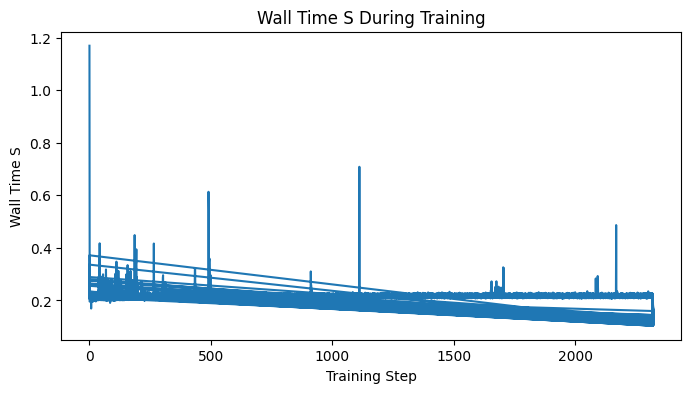

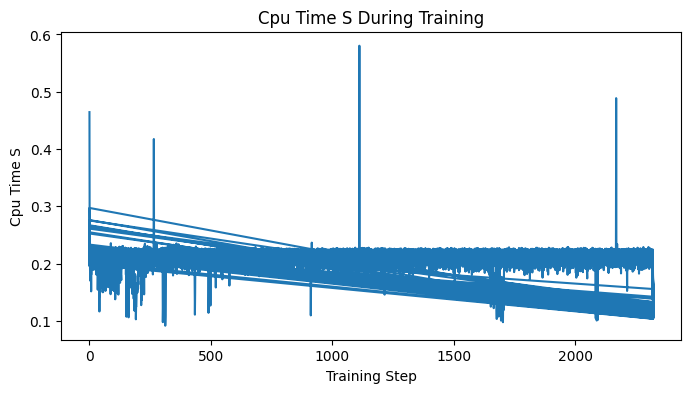

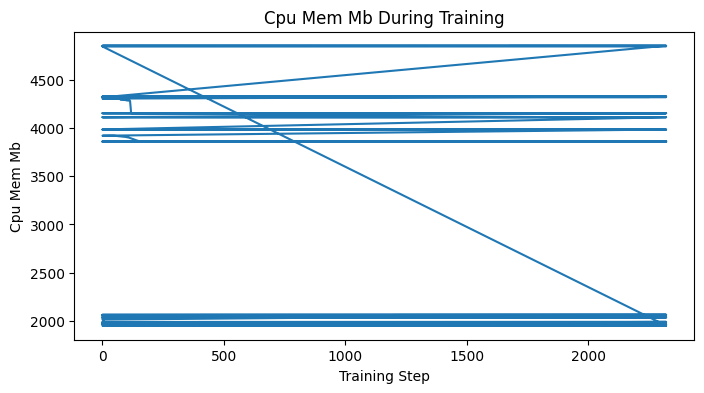

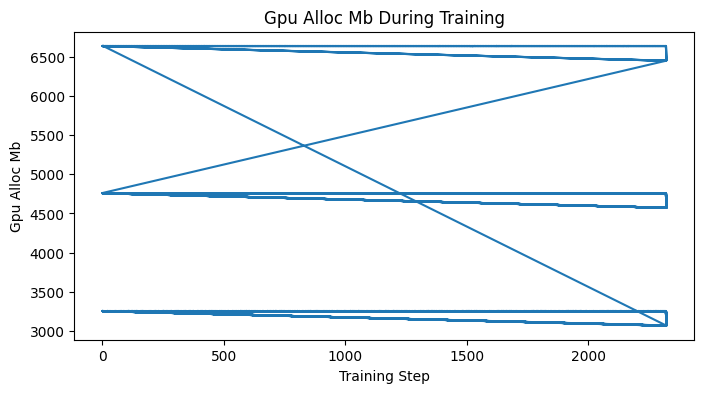

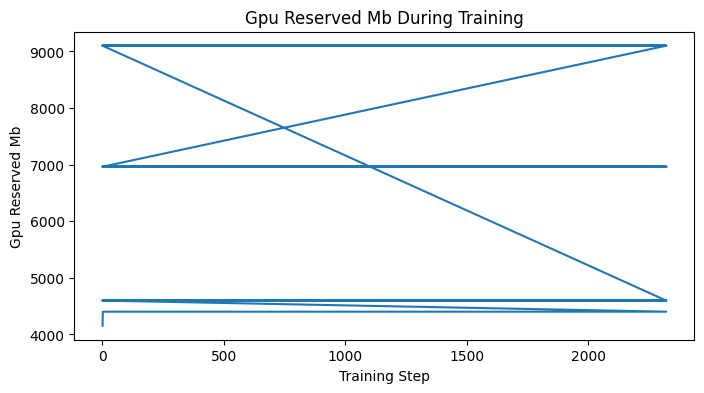

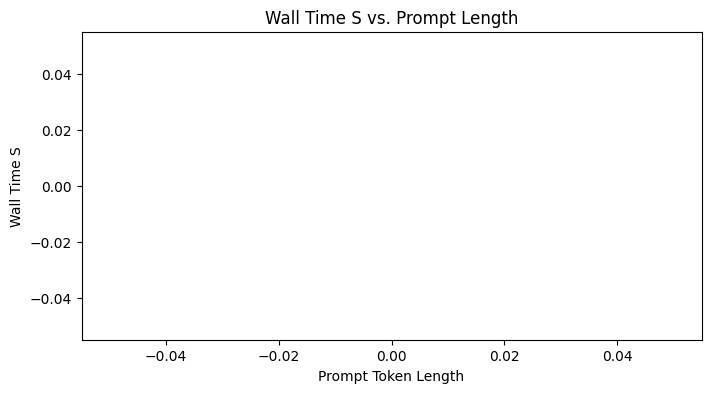

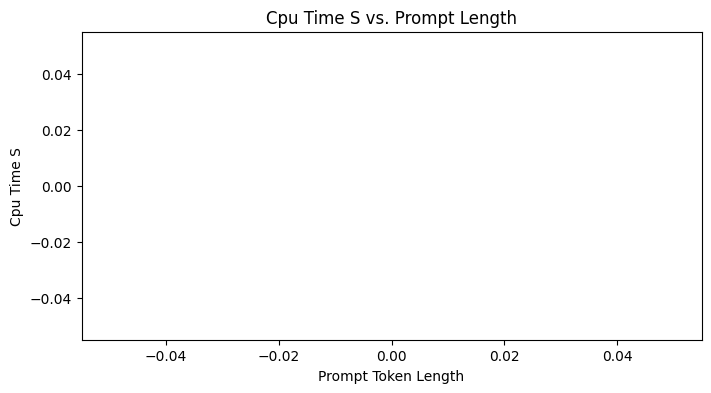

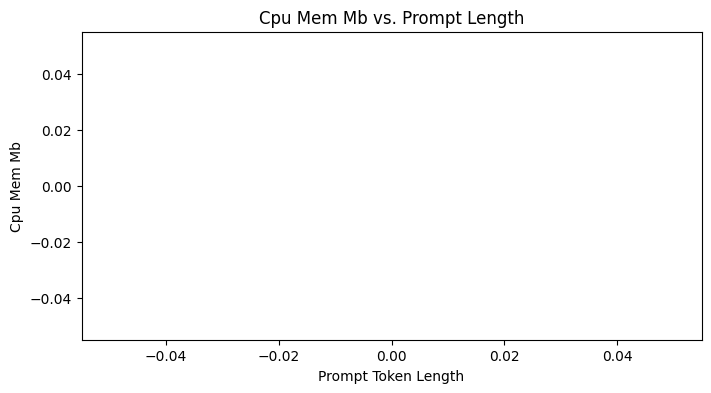

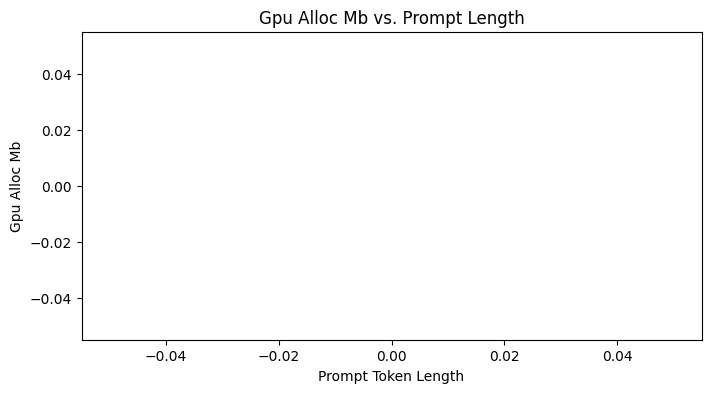

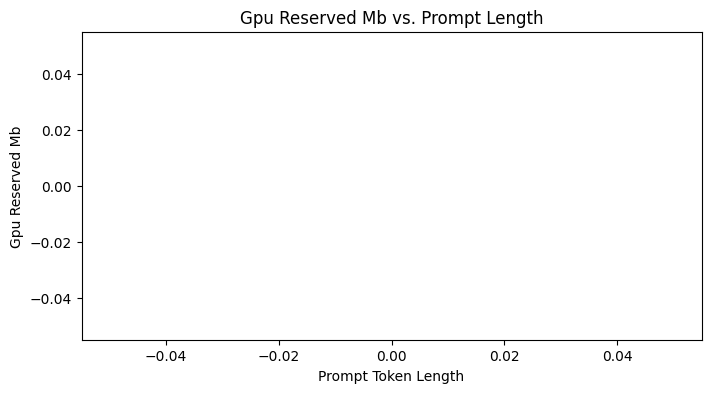

In [ ]:
# Plot usage
print("Custom Model Plots")
tracker.plot()